In [1]:
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
%matplotlib inline

In [2]:
from matplotlib import font_manager, rc

font_name = font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name()
plt.rc('font', family=font_name)

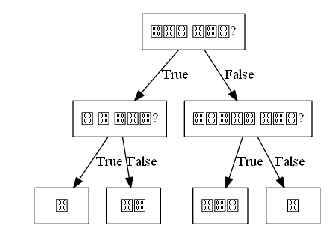

In [3]:
# graphviz, python-graphviz 설치해야 함
# [중요] pillow 패키지 버전을 4.0.0 을 사용해야 함 (최선은 5.0.1)
# Anaconda Navigator 에서 downgrade 할 수 있음
mglearn.plots.plot_animal_tree()

유방암데이터를 활용하여 결정트리의 사전 가지치기의 효과를 알아보자

사전 가지치기(pre-pruning) 
- 트리의 최대 깊이나 리프의 최대 개수를 제한 하는 방법
- 노드가 분할하기 위한 포인트의 최소 갯수를 지정하는 방법

Sci-kit Learn에서 결정트리는 DecisionTreeRegression 과 DecisionTreeClassifier 에 구현 되어 있으며,
사전 가지치기만 지원한다

In [4]:
from sklearn.tree import DecisionTreeClassifier

from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, stratify=cancer.target, random_state=42)
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)
print("훈련 세트 정확도: {:.3f}".format(tree.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(tree.score(X_test, y_test)))

훈련 세트 정확도: 1.000
테스트 세트 정확도: 0.937


리프노드가 순수노드 이므로 훈련 세트는 100%의 정확도가 나오는데... 과대 적합의 경우일 수 있고...

max_depth 옵션을 활용하여 트리의 성장에 제한을 두고 모델을 만들어 보자
그러면 테스트 세트의 성능이 개선 될 것이다

In [5]:
tree = DecisionTreeClassifier(max_depth=4, random_state=0)
tree.fit(X_train, y_train)
print("훈련 세트 정확도: {:.3f}".format(tree.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(tree.score(X_test, y_test)))

훈련 세트 정확도: 0.988
테스트 세트 정확도: 0.951


결정 트리 시각화를 통한 분석 ???

export_graphviz 함수를 사용하여 트리를 시각화 할 수 있다.

In [6]:
from sklearn.tree import export_graphviz
export_graphviz(tree, out_file="tree.dot", class_names=["악성", "양성"],
                feature_names=cancer.feature_names, impurity=False, filled=True)

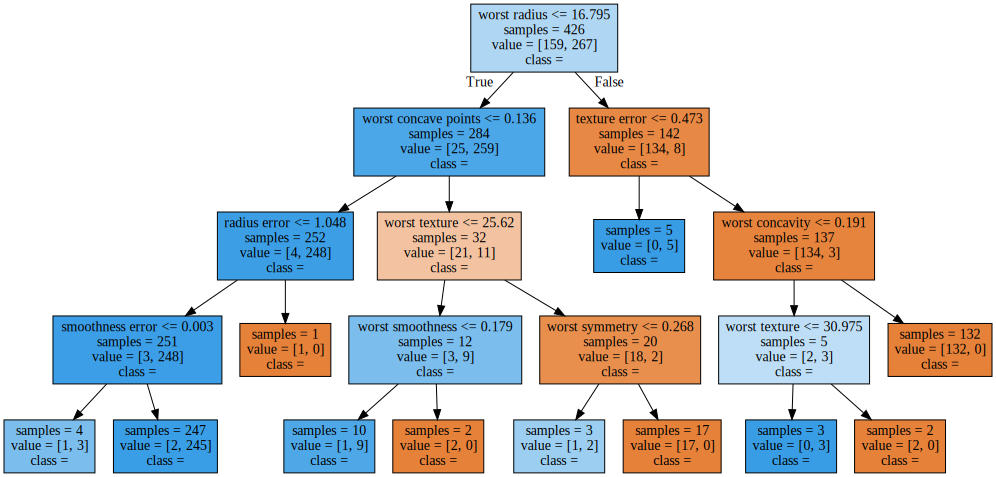

In [28]:
import graphviz

with open("tree.dot", 'rt', encoding='UTF8') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

트리의 특성 중요도(Feature Importance)

트리의 작동 속성에 대한 요약을 한눈에 볼 수 있다. 
0 부터 1까지의 값을 가지며 1에 가까울 수록 완벽하게 타겟 클라스를 예측 했다는 의미
전체의 합은 항상 1이다.

In [8]:
print("특성 중요도:\n{}".format(tree.feature_importances_))

특성 중요도:
[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.01019737  0.04839825  0.          0.
  0.0024156   0.          0.          0.          0.          0.
  0.72682851  0.0458159   0.          0.          0.0141577   0.          0.018188
  0.1221132   0.01188548  0.        ]


In [9]:
cancer.data.shape

(569, 30)

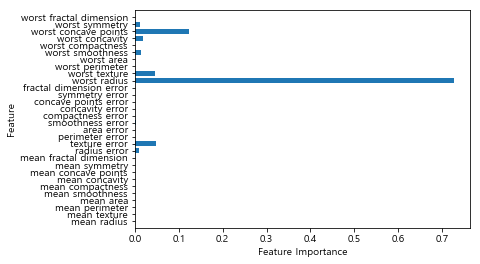

In [10]:
def plot_feature_importances_cancer(model):
    n_features = cancer.data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), cancer.feature_names)
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

plot_feature_importances_cancer(tree)

첫번째 노드에서 사용한 특성 worst radius 이 가장 중요한 특성으로 나타 나는데, 이는 첫번째 노드가 잘 설정되었다는 우리의 관찰을 뒷받침해 준다.

그러나 어떤 특성의 feature_importance_ 의 값이 낮다고 해서 이 특성이 유효하지 않다는 의미는 아니다.
단지 그 트리가 그 특성을 선택하지 않았다는 것일 뿐이며 다른 특성이 동일한 정보를 지니고 있어서 일 수 있다.

선형 모델의 계수와는 달리, 특성 중요도는 항상 양수이며 특성이 어떤 클래스를 지지 하는지는 알 수 없다,

특성 중요도의 값은 worst radius가 중요하다고는 알려 주지만 양성을 의미하는지 악성을 의미하는지는 알 수 없다.
사실 특성과 클래스 사이에는 간단하지 않은 관계가 있을 수 있으며, 다음의 예에서 살펴 보도록 하자.

Feature importances: [ 0.  1.]


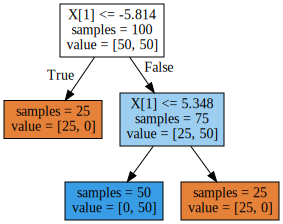

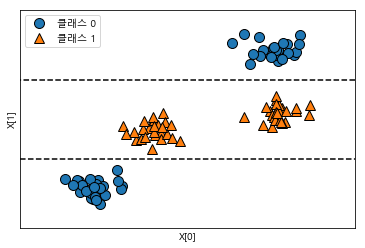

In [11]:
tree = mglearn.plots.plot_tree_not_monotone()
display(tree)

이그림은 두개의 특성과 두개의 클래스를 가진 데이터셋을 보여준다.
X[1]에 있는 정보만 사용 되었고 X[0]에 있는 정보는 전혀 사용 되지 않았다.

하지만 X[1]과 출력 클래스와의 관계는 단순하게 비례 또는 반비례하지도 않는다.
즉, X[1]의 값이 높으면 클래스 0 이고 낮으면 클래스 1 이라 말할 수 없다

DecisionTreeRegressor를 사용하면 회귀 결정 트리기반의 모델을 만들 수 있는데, Exploration이 어렵다.
즉, 회귀를 위한 트리기반 모델은 훈련데이터 밖의 포인트에 대하여 예측을 할 수 없다

컴퓨터 메모리 가격 동향 데이터세트를 예로 설명해 보자

x축은 날짜 y축은 해당연도의 RAM 1메가 바이트 가격

In [12]:
import pandas as pd
import os
ram_prices = pd.read_csv(os.path.join(mglearn.datasets.DATA_PATH, "ram_price.csv"))
ram_prices.head()

,Unnamed: 0,date,price
0,0,1957.0,411041792.0
1,1,1959.0,67947725.0
2,2,1960.0,5242880.0
3,3,1965.0,2642412.0
4,4,1970.0,734003.0


D:\Anaconda3\lib\site-packages\matplotlib\mathtext.py:866: MathTextWarning: Font 'default' does not have a glyph for '-' [U+2212]
  MathTextWarning)
D:\Anaconda3\lib\site-packages\matplotlib\mathtext.py:867: MathTextWarning: Substituting with a dummy symbol.
  warn("Substituting with a dummy symbol.", MathTextWarning)


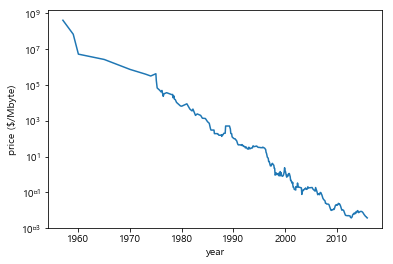

In [13]:
import pandas as pd
ram_prices = pd.read_csv(os.path.join(mglearn.datasets.DATA_PATH, "ram_price.csv"))

plt.semilogy(ram_prices.date, ram_prices.price)
plt.xlabel("year")
plt.ylabel("price ($/Mbyte)");

# 로그 스케일로 그린 RAM 가격 동향 ( 로그를 활용하여 선형적으로 표시하기 위함)

날짜 특성 하나만으로 2000년 전까지의 데이터로 부터 2000년 후의 가격을 예측해 보자

여기서는 간단히 DecisionTreeRegressor 와 LinearRegression 을 비교해 보자

In [14]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

# 2000년 이전을 훈련 데이터로, 2000년 이후를 테스트 데이터로 만듭니다
data_train = ram_prices[ram_prices.date < 2000]
data_test = ram_prices[ram_prices.date >= 2000]

# 가격 예측을 위해 날짜 특성만을 이용합니다
X_train = data_train.date[:, np.newaxis]
# 데이터와 타깃 사이의 관계를 간단하게 만들기 위해 로그 스케일로 바꿉니다
y_train = np.log(data_train.price)

tree = DecisionTreeRegressor().fit(X_train, y_train)
linear_reg = LinearRegression().fit(X_train, y_train)

# 예측은 전체 기간에 대해서 수행합니다
X_all = ram_prices.date[:, np.newaxis]

pred_tree = tree.predict(X_all)
pred_lr = linear_reg.predict(X_all)

# 예측한 값의 로그 스케일을 되돌립니다
price_tree = np.exp(pred_tree)
price_lr = np.exp(pred_lr)

D:\Anaconda3\lib\site-packages\matplotlib\mathtext.py:866: MathTextWarning: Font 'default' does not have a glyph for '-' [U+2212]
  MathTextWarning)
D:\Anaconda3\lib\site-packages\matplotlib\mathtext.py:867: MathTextWarning: Substituting with a dummy symbol.
  warn("Substituting with a dummy symbol.", MathTextWarning)


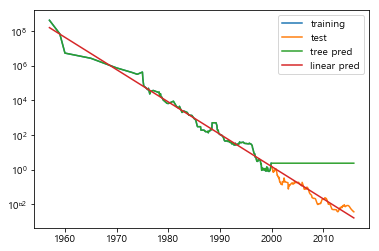

In [15]:
plt.semilogy(data_train.date, data_train.price, label="training")
plt.semilogy(data_test.date, data_test.price, label="test")
plt.semilogy(ram_prices.date, price_tree, label="tree pred")
plt.semilogy(ram_prices.date, price_lr, label="linear pred")
plt.legend();

트리 모델은 트리 복잡도에 제한을 두지 않아서 모든 훈련데이터에 대해 완벽하게 예측을 하는데,
모델이 가진 데이터 범위를 벋어나면 단순히 마지막 포인트를 이용해 예측하는 것이 전부 입니다.

트리모델은 새로운 데이터를 예측할 능력이 없다. 

(종합 정리) 트리모델

(1) 사전 가지치기 매개 변수
- max_depth, max_leaf_nodes, min_samples_leaf 중 하나만 지정해도 과대 적합을 막을 수 있다.

(2) 만들어진 모델의 시각화가 뛰어나 비전문가의 이해가 쉬워짐

(3) 데이터의 스케일에 구애를 받지 않는다
- 각 특성이 개별적으로 처리되어 데이터를 분할 하므로 특성의 정규화나 표준화가 필요 없다
- 특히 스케일이 서로 다르거나 이진 특성과 연속적인 특성이 혼합되어 있을 때도 잘 작동한다.

(4) 단점은 사전 가지 치기에도 과대적합이 발생하여 일반화 성능이 떨어지는 경우가 있다는 점
- 따라서 앙상블 모델을 활용하여 단점을 극복한다.

2.3.6 결정트리의 앙상블

앙상블은 여러 머신러닝의 모델을 연결하여 더 강력한 모델을 만드는 기법이다
결정트리의 단점인 과대 적합을 피하는방법

(1)랜덤 포레스트(random forest)

(2)그래디언트 부스팅(gradient boosting)

Random Forest

(1) 정의
조금씩 다른 여러 결정 트리의 묶음

(2) 배경 
잘 작동하되 서로 다른 방향으로 과대적합된 트리를 많이 만들면 그 결과를 평균냄으로 모델의 예측 성능은 유지하면서 과대적합된 양을 줄일 수 있다.

(3) 구현 전략
- 결정 트리를 많이 만들어야 한다
- 각각의 트리는 타겟 예측을 잘 해야 하고 다른 트리와 구별 되어야 한다
- 트리들이 달라지도록 트리생성 시 무작위성을 주입해야 한다.
  (가) 트리를 만들 때 사용하는 데이터 포인트를 무작위로 선택하는 방법
  (나) 분할 테스트에서 특성을 무작위로 선택하는 방법


랜덤 포레스트 구축

부트스트램 샘플을 사용하여 트리가 조금씩다른 데이터셋을 이용해 만들어지게 하고, 각 노드에서 특성의 일부만을 사용하게 하여 랜덤포레스트의 모든 트리가 서로 달라지도록 만들어 학습 시킴

(1) 생성할 트리의 갯수 정하기
- n_estimators 매개 변수(RandomForestRegressor 나 RandomForestClassifier)
- 여기서는 10개 필요하다고 가정하자

(2) 부트스트랩 샘플(bootstrap sample) 생성
- 목적: 트리의 독립성 보장을 위해서는 각 트리가 고유하게 만들어 지도록 무작위적인 선택을 해야한다
- 방법: n_samples개의 데이터 포인트 중에서 무작위로 데이터를 n_samples 횟수 만큼 반복 추출함
- 결과: 원래 데이터셋과 크기는 같지만, 대략 1/3 정도는 누락이 되고 나머지는 반복되는 값으로 채워짐
- 예시: [a, b, c, d] ==> [b, d, d, c] or [d, a, d, a] or ....

(3) 각각의 데이터셋으로 결정트리 만들기
- 차별점: 전체 특성을 대상으로 하는 것이 아니라 후보 특성을 무작위로 선택하여 그 후보들만으로 테스트를 함
- max_features 매개변수: 몇개의 후보 특성을 고를지 결정해야 함
- 따라서 트리의 각 노드는 다른 후보 특성들을 사용하여 테스트를 진행함

(4) max_features 사용시 유의점
- max_features의 값을 크게 하면 트리들은 매우 비슷해 지고 가장 두드러진 특성을 이용해 맞추어짐
- 예시: max_features 를 n_features로 하면 모든 특성을 고려해야 함으로 특성 선택의 무작위성이 없음
- max_features의 값을 작게 하면 트리들은 많이 달라지고 데이터에 맞추기 위해 깊이가 깊어짐
- 예시: max_features=1로 하면 테스트할 특성을 고를 필요없이 선택된 특성의 임계치만 찾으면 됨

(5) 최종 모델 선택
- 먼저 모든 트리의 예측을 하게함
- 회귀의 경우는 이 예측들을 평균하여 최종 예측을 만듬
- 분류의 경우는 약한 투표 전략 = 각 트리는 출력 레이블의 확률을 제공하고 이를 평균내어 가장 높은 것 선택

two_moon 데이터 셋을 가지고 5개의 트리로 구성된 랜덤 포레스트 모델

In [16]:
from sklearn.datasets import make_moons

moons = make_moons()
moons.shape

AttributeError: 'tuple' object has no attribute 'shape'

In [17]:
from sklearn.datasets import make_moons

moons = make_moons()
moons

(array([[  9.03976974e-01,  -4.95379113e-01],
        [  8.71318704e-01,   4.90717552e-01],
        [  1.87131870e+00,   9.28244800e-03],
        [  9.90311321e-02,   6.61162609e-02],
        [  2.22520934e-01,   9.74927912e-01],
        [ -5.18392568e-01,   8.55142763e-01],
        [  1.99794539e+00,   4.35929780e-01],
        [  8.40400105e-01,  -4.87181783e-01],
        [ -9.49055747e-01,   3.15108218e-01],
        [  1.59599895e-01,   9.87181783e-01],
        [  6.23489802e-01,   7.81831482e-01],
        [  1.28681296e-01,   9.28244800e-03],
        [  5.37461710e-01,  -3.86599306e-01],
        [  1.98155916e+00,   3.08841371e-01],
        [  3.27699110e-01,  -2.40277997e-01],
        [  1.61911895e-01,  -4.55349012e-02],
        [  8.20998618e-03,   3.72122838e-01],
        [ -3.20515776e-02,   9.99486216e-01],
        [  8.38088105e-01,   5.45534901e-01],
        [  1.40478334e+00,  -4.14412623e-01],
        [ -1.59599895e-01,   9.87181783e-01],
        [ -9.81559157e-01,   1.911

In [18]:
from sklearn.datasets import make_moons

moons = make_moons()
import pandas as pd
moons_df = pd.Series(moons)
moons_df.head()

0    [[1.94905574701, 0.184891781976], [-0.15959989...
1    [1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, ...
dtype: object

In [19]:
moons_df.shape

(2,)

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, noise=0.25, random_state=3)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

forest = RandomForestClassifier(n_estimators=5, random_state=2)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=2, verbose=0, warm_start=False)

랜덤포레스트 안에 만들어진 트리는 estimator_ 속성에 저장됩니다
각 트리에서 학습된 결정 경계와 이를 취합해 만든 결정경계를 함께 시각화 해보자

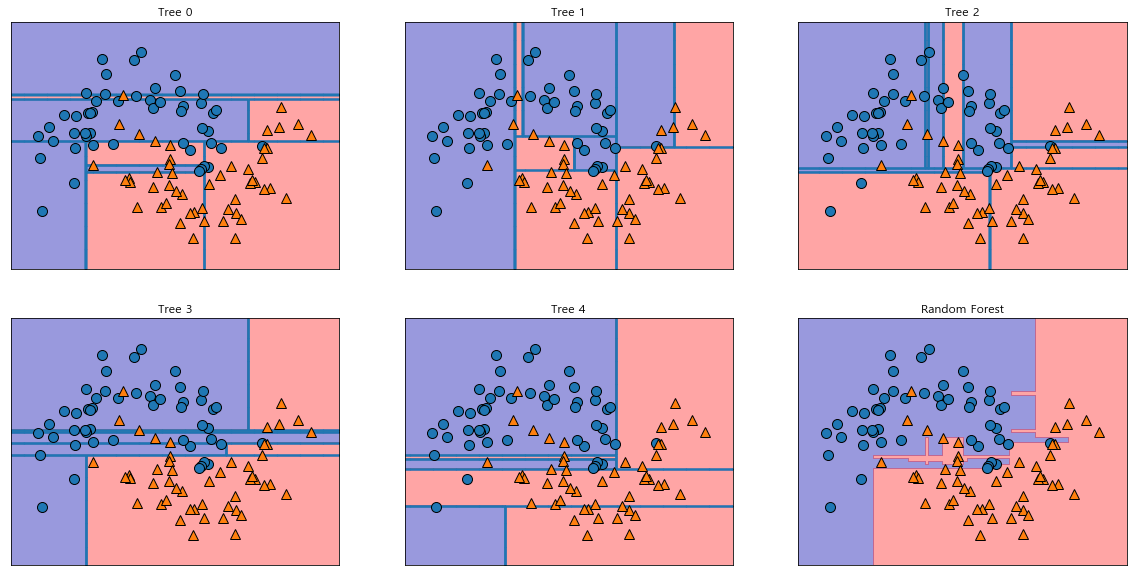

In [21]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, (ax, tree) in enumerate(zip(axes.ravel(), forest.estimators_)):
    ax.set_title("Tree {}".format(i))
    mglearn.plots.plot_tree_partition(X, y, tree, ax=ax)
    
mglearn.plots.plot_2d_separator(forest, X, fill=True, ax=axes[-1, -1], alpha=.4)
axes[-1, -1].set_title("Random Forest")
mglearn.discrete_scatter(X[:, 0], X[:, 1], y);

다섯개의 트리가 만든 결정 경계는 확실히 다릅니다.
부트스트랩 샘플링 때문에 훈련 포인트가 서로 달라 각 트리는 불완전 합니다.

그러나 랜덤포레스트는 개개의 트리보다는 덜 과대적합되고 훨씬 좋은 결정 경계를 만들어 줍니다.

유방암 데이터 세트로 100개의 트리로 이루어진 랜덤 포레스트 모델 만들기

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)
forest = RandomForestClassifier(n_estimators=100, random_state=0)
forest.fit(X_train, y_train)

print("훈련 세트 정확도: {:.3f}".format(forest.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(forest.score(X_test, y_test)))

훈련 세트 정확도: 1.000
테스트 세트 정확도: 0.972


랜덤포레스트는 아무런 매개 변수 튜닝 없이 선형 모델이나 단일 결정 트리 보다 높은 97%의 정확도를 나타냄.
물론 사전 가기치기나 max_features 매개변수를 활용하여 튜닝도 가능

랜덤 포레스트의 특성 중요도

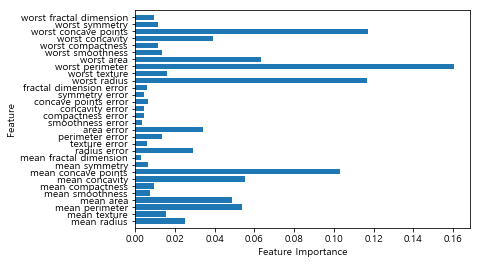

In [23]:
plot_feature_importances_cancer(forest)

랜덤포레스트의 경우 단일 결정트리 경우 보다 훨씬 많은 특성이 0 이상의 중요도를 갖는다

단일 트리와 마찬가지로 worst radius 도 많은 정보를 가지고 있는 것으로 보고 있지만,
랜덤 포레스트에서는 worst perimeter 를 가장 많은 정보를 가지고 있는 특성으로 보고 있음

랜덤 포레스트에 대해 알아 두기

(1) n_jobs 매개변수 
- 사용할 CPU 코어의 수
- n_jobs=-1 이면 컴퓨터의 모든 코어를 사용함

(2) random_state 
- random_state를 지정하면 혹은 지정하지 않으면 전혀 다른 모델이 만들어 진다.
- 랜덤 포레스트의 트리가 많을 수록 random_state 값의 변화에 따른 변동이 작아진다.
- 만약 같은 결과를 만들어야 한다면 random_state 를 고정 하여야 한다

(3) 고차원의 데이터(예: 텍스트 데이터)나 속도와 메모리 제약이 있는 경우는 선형모델이 유리

(4) n_estimators 는 클수록 좋고, max_depth 로 사전 가지치기가 가능함

(5) max_features의 경우는 기본값이 분류는 sqrt(n_features) 이고, 회귀는 n_features 인데,
    대개의 경우 그대로 쓰는 것이 좋으나 변경 하면 가끔 성능이 좋아짐
    
(6) max_leaf_nodes 매개 변수도 성능을 향상 시키는데 도움이 될 수 있음

Gradient Boosting

(1) 정의
이전 트리의 오차를 보완하는 방식으로 순차적으로 트리를 만듬. 
무작위성이 없고, 대신 강력한 사전 가지치기
하나에서 다섯 정도의 깊지않은 트리를 사용함

(2) 배경 
얕은 트리같은 간단한 모델(약한 학습기)을 많이 연결하여 메모리를 적게 사용하게 하고 빠른 예측을 할 수 있음

(3) 구현 전략
- 매개변수 설정에 조금 더 민감하지만 잘 조정하면 더 높은 정확도를 가져다 줌 
- learning_rate: 이전 트리의 오차를 얼마나 강하게 보정할 것인지를 제어함
- n_estimators의 값을 키우면 앙상블에 트리가 더 많이 추가되어 모델의 복잡도가 커지고 훈련세트의 실수를 바로 잡   을 기회가 많아짐


유방암 데이터셋으로 GradientBoostingClassifier를 상요한 예

기본값인깊이가 3인 트리 100개와 학습률 0.1을 사용

In [24]:
from sklearn.ensemble import GradientBoostingClassifier

X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train)

print("훈련 세트 정확도: {:.3f}".format(gbrt.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(gbrt.score(X_test, y_test)))

훈련 세트 정확도: 1.000
테스트 세트 정확도: 0.958


훈련세트의 정확도가 100%인것으로 미루어 과대적합임

트리의 최대 깊이를 줄여 사전 가기치기를 하거나 학습율울 낮추는 방법을 시도

In [25]:
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)

print("훈련 세트 정확도: {:.3f}".format(gbrt.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(gbrt.score(X_test, y_test)))

훈련 세트 정확도: 0.991
테스트 세트 정확도: 0.972


In [26]:
gbrt = GradientBoostingClassifier(random_state=0, learning_rate=0.01)
gbrt.fit(X_train, y_train)

print("훈련 세트 정확도: {:.3f}".format(gbrt.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(gbrt.score(X_test, y_test)))

훈련 세트 정확도: 0.988
테스트 세트 정확도: 0.965


특성 중요도 시각화

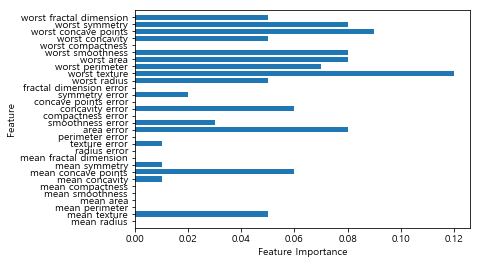

In [27]:
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)

plot_feature_importances_cancer(gbrt)

랜덤포레스트와 비슷하나 그래디언트에서는 일부 특성은 완전 무시되고 있음

통상 랜덤포레스트를 먼저 적용해 보고 특별한 경우만 그래디언트 사용한다

learning_rate를 낮추면 통상 n_estimators를 높이는 게 좋으며, n_estimators는 많을 수록 좋습니다.